In [1]:
COLAB: bool = True
if COLAB:
  !git clone https://github.com/RubenCid35/6GSmartRRM
  !mv 6GSmartRRM/* .


Cloning into '6GSmartRRM'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 100 (delta 40), reused 73 (delta 22), pack-reused 0 (from 0)
Receiving objects: 100% (100/100), 334.64 KiB | 2.61 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# simple data manipulation
import numpy  as np
import pandas as pd

# deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lrs
from   torch.utils.data import DataLoader, TensorDataset, random_split

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

from collections import defaultdict

# results logging
import wandb
wandb.login()

# progress bar
from   tqdm.notebook import tqdm, trange

# remove warnings (remove deprecated warnings)
import warnings
warnings.simplefilter('ignore')

# visualization of resultsa
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from   matplotlib.ticker import MaxNLocator
import seaborn           as sns

# Graph Algorithms.
import networkx as nx

# Google Colab (many lines are removed)
import os
import zipfile
from google.colab import drive
from distutils.dir_util import copy_tree

# wheter we are using colab or not
if not COLAB and not os.path.exists('./data/simulations'):
    os.chdir('..')

# Simulation Settings
from g6smart.sim_config import SimConfig
from g6smart.evaluation import rate_torch as rate_metrics

config = SimConfig(0)
config

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rubencid001 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Simulation Parameters: 

|                      name |                     value |
---------------------------------------------------------
|        num_of_subnetworks |                   20.0000 |
|              n_subchannel |                    4.0000 |
|             deploy_length |                   20.0000 |
|             subnet_radius |                    1.0000 |
|                      minD |                    0.8000 |
|               minDistance |                    2.0000 |
|                 bandwidth |             40000000.0000 |
|              ch_bandwidth |             10000000.0000 |
|                        fc |           6000000000.0000 |
|                    lambdA |                    0.0500 |
|                  clutType |                     dense |
|                  clutSize |                    2.0000 |
|                  clutDens |                    0.6000 |
|                   shadStd |                    7.2000 |
|                 max_power |                  

In [4]:
def setup_wandb(name: str, config: dict[str, float]):
    config['name'] = name
    return wandb.init(
        project="6GSmartRRM",
        name   = name,
        config = config
    )


## Simulations and Information

Thanks to the given scripts, we can load a group of generated simulations. They don't have any solutions (neither approximations).

In [5]:
# Moung Google Drive Code
if COLAB:
    drive.mount('/content/drive')

    # Move Simulations to avoid cluttering the drive folder
    if not os.path.exists('/content/simulations'):
      os.mkdir('/content/simulations')

    if list(os.listdir('/content/simulations')) == []:
      copy_tree('/content/drive/MyDrive/TFM/simulations', '/content/simulations')

    # unzip all simulations
    print("Name of the already simulated data: \n", )
    for zip_file in os.listdir('/content/simulations'):
        if zip_file.endswith('.zip'):
            print(" ----> " + zip_file)
            with zipfile.ZipFile("/content/simulations/" + zip_file, 'r') as zip_ref:
                zip_ref.extractall('/content/simulations/')

    SIMULATIONS_PATH: str = "/content/simulations"
else:
    if not os.path.exists('./data/simulations'): os.mkdir('./data/simulations')
    for zip_file in os.listdir('data'):
        if zip_file.endswith('.zip'):
            print(" ----> " + zip_file)
            with zipfile.ZipFile("./data/" + zip_file, 'r') as zip_ref:
                zip_ref.extractall('./data/simulations')
    SIMULATIONS_PATH: str = "./data/simulations"

Mounted at /content/drive
Name of the already simulated data: 

 ----> simulations-200K-sisa.zip


In [6]:
cmg   = np.load(SIMULATIONS_PATH + '/Channel_matrix_gain.npy')
sisa_alloc = np.load(SIMULATIONS_PATH + '/sisa-allocation.npy')

# get sample from all
n_sample = 200_000
cmg   = cmg[:n_sample]
sisa_alloc = sisa_alloc[:n_sample]

n_sample = cmg.shape[0]
K, N, _  = cmg.shape[1:]

shape    = lambda s: " x".join([f"{d:3d}" for d in s])
print(f"channel    matrix shape: {shape(cmg.shape)} \nallocation matrix shape: {shape(sisa_alloc.shape)}")

channel    matrix shape: 200000 x  4 x 20 x 20 
allocation matrix shape: 200000 x 20


## Publications to revise

* (power) Power control for 6g industrial wireless subnetworks: A graph neural network approach
* (allocation) Towards 6g in-x subnetworks with sub-millisecond communication cycles and extreme reliability
* (power) Multi-agent deep reinforcement learning for dynamic power allocation in wireless networks
* (both) Multi-agent reinforcement learning for dynamic resource management in 6g in-x subnetworks
* (both) Multi-agent dynamic resource allocation in 6g in-x subnetworks with limited sensing information

## First Proposal

In this proposal, we could mixed different implementations for optimization of problem.
We can only consider the following setup:

1. Determine a almost optimal subband allocation for the networks. We could use a power selection of $p = p_{max}$
2. Based on the obtained allocation, we determine a power control for each subnetwork that minimizes the used
power and does not deteriorite the signal.

For the subband allocation, we could consider the implementation from this [publication](https://ieeexplore.ieee.org/document/10597067).


In [7]:
# First Step: Subband allocation problem
class RateConfirmAllocModel(nn.Module):
    def __init__(self, n_subnetworks: int, n_bands: int,
                 hidden_dim: int = 1000, hidden_layers: int = 4,
                 dropout: float | None = 0.01,
                 keep_band_wise: bool = False) -> None:
        super().__init__()

        # initialize state
        self.n = n_subnetworks
        self.k = n_bands

        # preprocessing options
        self.keep_band_wise = keep_band_wise

        # DNN architecture
        self.input_size = self.n * self.n if not self.keep_band_wise else self.n * self.n * self.k
        self.output_size = self.n * self.k

        last_layer = -2 if dropout is None else -3
        layers = [] # with batch norm at start
        dims = [self.input_size] + [hidden_dim] * (hidden_layers + 1) + [self.output_size]
        for i in range(1, len(dims)):
            # linear layers with HE initialization
            layers.append(nn.Linear(dims[i - 1], dims[i]))
            torch.nn.init.kaiming_normal_(layers[-1].weight, nonlinearity='relu')
            layers.append(nn.ReLU())

            # apply dropout. We have a lot of parameters, it is required
            layers.append(nn.BatchNorm1d(dims[i]))
            if isinstance(dropout, float):
              layers.append(nn.Dropout(dropout))

        layers = layers[:last_layer]
        self.model = nn.Sequential(*layers)

    def preprocess(self, channel_gain: np.ndarray | torch.Tensor ) -> torch.Tensor:
        if not self.keep_band_wise and len(channel_gain.shape[1:]) == 3:
            channel_gain = torch.mean(channel_gain, dim = 1)
        elif self.keep_band_wise and len(channel_gain.shape[1:]) != 3:
            raise ValueError("The model expects a channel gain matrix (BxKxNxN)")

        channel_gain = torch.tensor(channel_gain, requires_grad=False).float()

        # flatten the channel information
        channel_gain = channel_gain.flatten(start_dim=1)

        # transform to dbm scale to restrict value range
        channel_gain = 10 * torch.log10(channel_gain + 1e-9) # transform to Dbm

        # normalize to values.
        cavg = channel_gain.mean(dim = 1, keepdim = True)
        cstd = channel_gain.std( dim = 1, keepdim = True)
        return (channel_gain - cavg) / cstd

    def forward(self, channel_gain: torch.Tensor, t: float = 1.0 ) -> torch.Tensor:
        # preprocess to obtain a NxN channel gain
        channel_gain = self.preprocess(channel_gain)
        # apply model
        channel_network = self.model(channel_gain)
        # determine best allocation
        channel_network = channel_network.reshape(-1, self.k, self.n)
        # derive probabilities
        return F.softmax(channel_network / t, dim = 1)

The used loss function in the first-stage correspond to modified version of:

$$ \sum \mathbb{E}(\hat{R} > R^{REQ}) $$


In [8]:
def loss_fullfield_req(config: SimConfig, C: torch.Tensor, A: torch.Tensor, req: float) -> torch.Tensor:
    # calculate shannon rate
    sinr = rate_metrics.signal_interference_ratio(config, C, A, None)
    rate = torch.sum(A * torch.log2(1 + sinr), dim = 1)

    rate = F.sigmoid(req - rate) / req
    rate = torch.sum(rate, dim=1)
    return rate

class TemperatureScheduler:
    def __init__(self, tinit=1.0, gamma=0.99, tmin = 1e-10):
        self.tinit = tinit
        self.gamma = gamma
        self.tmin  = tmin
        self.step_count = 0

    def step(self):
        """Increases tau based on an exponential schedule."""
        temp = self.tinit * self.gamma ** self.step_count
        self.step_count += 1
        return max(temp, self.tmin)

In [9]:
from IPython.display import clear_output
def real_time_plot(*metrics):
    assert len(metrics) % 2 == 0, "A odd pair of metrics is required"
    clear_output(wait=True)  # Clear the previous plot

    fig, ax = plt.subplots(1, 2, figsize=(14, 4))  # Two subplots, stacked vertically
    # Plot loss
    for i, loss in enumerate(metrics[:len(metrics) // 2]):
      ax[0].plot(loss, label = f"loss: {i}")
    ax[0].set_title('Real-Time Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    # Plot metric (e.g., SINR or accuracy)
    for i, metric in enumerate(metrics[len(metrics) // 2:]):
      ax[1].plot(metric, label = f"metric: {i}")
    ax[1].set_title('Real-Time Metric')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Bit Rate (Mbps)')
    ax[1].legend()

    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()


In [10]:
def binarization_error(alloc: torch.Tensor) -> float:
    rounded = torch.round(alloc)
    return torch.mean(torch.abs(alloc - rounded))

def update_metrics(metrics, A, C, config, req):
    A    = rate_metrics.onehot_allocation(A, 4, 20)
    sinr = rate_metrics.signal_interference_ratio(config, C, A, None)
    rate = rate_metrics.bit_rate(config, sinr, A)
    fairness = rate_metrics.jain_fairness(rate)
    spectral = rate_metrics.spectral_efficency(config, rate)
    plf      = rate_metrics.proportional_loss_factor(config, C, A, None)

    shannon  = torch.sum(A * torch.log2(1 + sinr), dim = 1)
    ecf_req  = torch.mean((shannon >= req).float(), dim = 1)

    metrics['bit-rate'] += rate.mean().item() / 1e6
    metrics['jain-fairness'] += fairness.mean().item()
    metrics['spectral-efficency'] += spectral.mean().item()
    metrics['proportional-loss' ] += plf.mean().item()
    metrics['over-requirement' ] += ecf_req.mean().item()
    return metrics

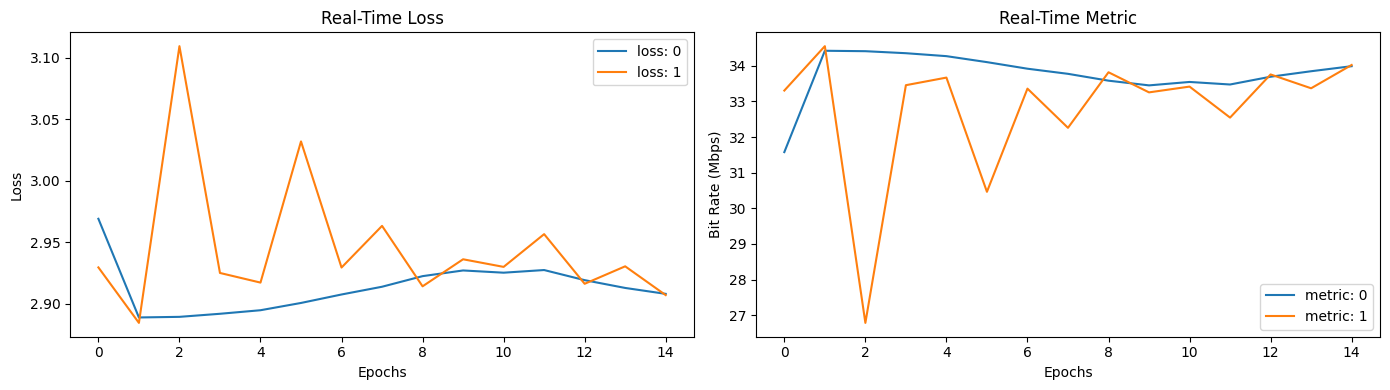

training step::   0%|          | 0/147 [00:00<?, ?batch/s]

In [ ]:
BATCH_SIZE: int = 1024
MAX_EPOCH : int = 200

# under ideal conditions, the max ideal shannon rate is around 4.
REQ: float      = 6.

# build datasets
TRAIN_SAMPLE: int = 150_000
VALID_SAMPLE: int =  50_000
#TESTS_SAMPLE: int =   0_000
whole_data = TensorDataset(torch.tensor(cmg).float())
train_data, valid_data = random_split(
    whole_data,
    [TRAIN_SAMPLE, VALID_SAMPLE], # , TESTS_SAMPLE
    torch.Generator().manual_seed(101)
)

train_data = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle = True)
valid_data = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle = True)
# tests_data = DataLoader(tests_data, batch_size=BATCH_SIZE)

# training config
LR: float  = 1e-3
HS: int    = 1024
HL: int    = 6
DP: float  = 0.1
KEEP_BANDS: bool = True

name  = "p1-alloc-dnn-01-01-base"
learning_config = {
    'batch-size': BATCH_SIZE,
    'n_epochs'  : MAX_EPOCH,
    'lr'        : LR,
    'dropout'   : DP,
    'hidden-dim': HS,
    'hidden-layers': HL,
    'keep-bands': KEEP_BANDS,
    'data-split': f"{TRAIN_SAMPLE}-{VALID_SAMPLE}-{0}",
    'network-req-nbit': f'{REQ:3.2f}',
    'network-req-snir': f'{2 ** (REQ) - 1}'
}

try: wandb.finish(quiet = True)
except: pass
run = setup_wandb(name, learning_config)
print("run config:", run.config)

# scheduler = lrs.CosineAnnealingLR(optimizer, T_max=0.1, eta_min = 0)
model = RateConfirmAllocModel(20, 4, HS, HL, DP, KEEP_BANDS).to(device)
optimizer = optim.Adam(model.parameters(), LR, weight_decay=1e-2)
scheduler = lrs.CosineAnnealingLR(optimizer, T_max=150, eta_min=1e-6)
temp_scheduler = TemperatureScheduler(1.0, 0.98)

train_loss, valid_loss, train_rate, valid_rate = [], [], [], []
for epoch in trange(MAX_EPOCH, desc = "training epoch", unit = "epoch"):
    real_time_plot(train_loss, valid_loss, train_rate, valid_rate)

    # training step
    model.train()
    training_loss = 0.
    train_binary_loss = 0.

    temp = temp_scheduler.step()
    training_metrics = defaultdict(lambda : 0)
    for sample in tqdm(train_data, desc = 'training step:', unit = 'batch', total = len(train_data), leave=False):
        optimizer.zero_grad()

        sample     = sample[0].to(device)
        alloc_prob = model(sample, temp)
        loss       = loss_fullfield_req(config, sample, alloc_prob, REQ).mean()
        training_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_binary_loss += binarization_error(alloc_prob).item()
        training_metrics = update_metrics(training_metrics, alloc_prob, sample, config, REQ)

    scheduler.step()
    training_loss = training_loss / len(train_data)
    train_binary_loss = train_binary_loss / len(train_data)
    training_metrics = { 'train-' + key: val / len(train_data) for key, val in training_metrics.items()}

    model.eval()
    validation_loss = 0.
    valid_binary_loss = 0.
    validation_metrics = defaultdict(lambda : 0.)
    for sample in tqdm(valid_data, desc = 'validation step:', unit = 'batch', total = len(valid_data), leave = False):
        sample     = sample[0].to(device)
        alloc_prob = model(sample, temp)
        loss       = loss_fullfield_req(config, sample, alloc_prob, REQ).mean()
        validation_loss += loss.item()

        valid_binary_loss += binarization_error(alloc_prob).item()
        validation_metrics = update_metrics(validation_metrics, alloc_prob, sample, config, REQ)

    validation_loss = validation_loss / len(valid_data)
    valid_binary_loss = valid_binary_loss / len(valid_data)

    validation_metrics = { 'valid-' + key: val / len(valid_data) for key, val in validation_metrics.items()}

    logged_values = {
        'train-loss': training_loss, 'valid-loss': validation_loss, 'temperature': temp,
        'train-binary-loss': train_binary_loss, 'valid-binary-loss': valid_binary_loss
    }

    logged_values.update(training_metrics)
    logged_values.update(validation_metrics)

    train_loss.append(training_loss)
    valid_loss.append(validation_loss)
    train_rate.append(training_metrics['train-bit-rate'])
    valid_rate.append(validation_metrics['valid-bit-rate'])
    wandb.log(logged_values)

wandb.finish()


In [ ]:
sisa_tensor = torch.tensor(sisa_alloc[-40_000:]).type(torch.int64).to(device)
data_tensor = torch.tensor(cmg[-40_000:]).to(device)
allc_tensor = model(data_tensor).to(device)

print(sisa_tensor.shape, data_tensor.shape, allc_tensor.shape)
print(update_metrics(defaultdict(lambda : 0), sisa_tensor, data_tensor, config, 3))
print(update_metrics(defaultdict(lambda : 0), allc_tensor, data_tensor, config, 3))



In [ ]:
sisa_sinr =

In [ ]:
channel = torch.tensor([[[
    [0.1, 0.0001, 0.0001],
    [0.0001, 0.2, 0.0005],
    [0.0001, 0.0005, 0.1]
], [
    [0.1, 0.0001, 0.0001],
    [0.0001, 0.2, 0.0005],
    [0.0001, 0.0005, 0.1]
]],
[[
    [0.1, 0.0001, 0.0001],
    [0.0001, 0.2, 0.0005],
    [0.0001, 0.0005, 0.1]
], [
    [0.1, 0.0001, 0.0001],
    [0.0001, 0.2, 0.0005],
    [0.0001, 0.0005, 0.1]
]],
[[
    [0.1, 0.0001, 0.0001],
    [0.0001, 0.2, 0.0005],
    [0.0001, 0.0005, 0.1]
], [
    [0.1, 0.0001, 0.0001],
    [0.0001, 0.2, 0.0005],
    [0.0001, 0.0005, 0.1]
]]])

alloc   = torch.tensor([[0, 1, 0], [1, 0, 0], [1, 0, 0]])
C       = channel.view(3, 2, 3, 3)
A       = rate_metrics.onehot_allocation(alloc, 2, 3)

print(C.shape, A.shape)
loss_fullfield_req(config, C, A, 8.)

In [ ]:
power = config.transmit_power
noise = config.noise_power

s1    = channel[0, 0, 2, 2] * power
i1    = torch.sum(channel[0, 0, 2, :]) * power - s1
s1 / (i1 + noise + 1e-9)